# House Prices Regression - Feature Engineering

## Executive summary

In round 1 of the analysis, I performed basic data cleaning and EDA. I fit the data using a list of regression models and I found out XGBOOST has the best performance without hyperparameter tuning. 

After round 1, I 

In this round. 

Goal: practice some data cleaning, feature engineering technics, and compare LASSO and XGBOOST algo. Resubmit prediction.

Key changes:  
- Chance ordinal variables to numeric. Candidates: LandSlope, ExterQual, ExterCond, BsmtQual, BsmtCond, BsmtExposure, HeatingQC, CentralAir, KitchenQual, FireplaceQu, GarageQual, GarageCond, PavedDrive
- Binning Neighborhood -> super high, super low
- Remove variables with low variance: Condition2, RoofMatl, Heating, 

Steps:

- EDA
    -- SalePrice only
    -- correlation include ordinal variables
    -- Focus on important variables
    -- Analyze outlier

- Data cleaning and Feature engineering 
- Feature selection

In [112]:
## install extension to allow cell collapse

# docker exec -it [containerID] bash
# pip install jupyter_nbextensions_configurator --user
# export PATH=$PATH:~/.local/bin
# jupyter nbextensions_configurator enable --user

In [113]:
# import
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import datetime

from sklearn import pipeline, base, decomposition, preprocessing, linear_model, ensemble, model_selection, metrics, svm, tree, neighbors, neural_network
import xgboost

%matplotlib inline

In [319]:
# function to make submission csv file with predicted values
def make_submission_file(y_pred, path='data/submissions/'):
    df = pd.DataFrame({'Id': df_test['Id'], 
                      'SalePrice': y_pred})
    file = path + 'sub_{}.csv'.format(datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S"))
    if not os.path.exists(path):
        os.makedirs(path)

    df.to_csv(file, index=False)

In [115]:
# an auxilary function to easily look at relationship between categorical variables and target variable
def plot_count_and_bar(x, y, data, figsize=(10, 4)):
    fig, ax = plt.subplots(1, 2, figsize=figsize)
    sns.countplot(x=x, data=data, ax=ax[0])
    sns.barplot(x=x, y=y, data=data, ax=ax[1])

In [116]:
def hist_box_qq_plot(series, figsize=(10, 5), y=None):
    ''' histgram, box and qq plot - univariate analysis for numeric variables
    '''
    _, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=figsize)
    sns.distplot(series, ax=ax1)
    _ = [item.set_rotation(45) for item in ax1.get_xticklabels()]  # adjust x_axis label rotation
    sns.boxplot(series, orient='v', ax=ax2)
    stats.probplot(series, sparams=(2,3), plot=ax3, fit=True)

    plt.subplots_adjust(bottom=0.1, right=1.8, top=0.9)  # adjust subplots so that they do not overlap

In [117]:
def plot_hist_box_qq_scatter(x, y, data, figsize=(20, 6)):
    fig, ax = plt.subplots(1, 4, figsize=figsize)
    sns.distplot(data[x], ax=ax[0])
    sns.boxplot(x=x, data=data, ax=ax[1], orient='v')
    stats.probplot(data[x], sparams=(2,3), plot=ax[2], fit=True)
    sns.scatterplot(x=x, y=y, data=data, ax=ax[3])
    
    plt.subplots_adjust(bottom=0.1, right=1.8, top=0.9)  # adjust subplots so that they do not overlap

In [118]:
def show_missing(df_train, df_test):
    ''' inspect number of missing values in train and test data set
    '''
    miss1 = df_train.isnull().mean()[lambda x: x>0].to_frame('train')
    miss2 = df_test.isnull().mean()[lambda x: x>0].to_frame('test')

    total_miss = pd.merge(miss1, miss2, left_index=True, right_index=True, how='outer').sort_values('train', ascending=False)
    total_miss['train_count'] = total_miss['train'] * len(df_train)
    total_miss['test_count'] = total_miss['test'] * len(df_test)

    print("{} out of {} variables contain missing values:\n".format(len(total_miss), len(df_train.columns)))
    return total_miss

## Data cleaning and feature engineering

In [119]:
# load raw data
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

### Check data completeness

In [120]:
show_missing(df_train, df_test)

34 out of 81 variables contain missing values:



,train,test,train_count,test_count
PoolQC,0.995205,0.997944,1453.0,1456.0
MiscFeature,0.963014,0.965045,1406.0,1408.0
Alley,0.937671,0.926662,1369.0,1352.0
Fence,0.807534,0.801234,1179.0,1169.0
FireplaceQu,0.472603,0.500343,690.0,730.0
LotFrontage,0.177397,0.155586,259.0,227.0
GarageFinish,0.055479,0.053461,81.0,78.0
GarageQual,0.055479,0.053461,81.0,78.0
GarageType,0.055479,0.052090,81.0,76.0
GarageYrBlt,0.055479,0.053461,81.0,78.0


### Identify variable type and encode ordinal variables

In [121]:
# start with original data type
print(df_train.dtypes.value_counts())
_cat_cols = df_train.drop('SalePrice', axis=1).select_dtypes(['O']).columns.tolist()
_num_cols = df_train.drop('SalePrice', axis=1).select_dtypes(['int64', 'float64']).columns.tolist()
print('\noriginal categorical variables are: ', _cat_cols)
print('\noriginal numeric variables are: ', _num_cols)

object     43
int64      35
float64     3
dtype: int64

original categorical variables are:  ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']

original numeric variables are:  ['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'Bedroom

We need to go through these variables to determine:
- clearly uninformative variables, for example Id, and variables with low variance
- true numeric variables
- categorical variables to apply One Hot Encoding (i.e. non-ordinal)
- categorical variables to apply Ordinal Encoding (i.e. ordinal)

We use some statistics and charting in combinantion with the data description to derive these.

In [122]:
for col in _cat_cols:
    # to do it nicely, we can create a df including:
    # count_%, count, avg_target_value_train, test_count
    print(df_train[col].value_counts(normalize=True, dropna=False), '\n')

RL         0.788356
RM         0.149315
FV         0.044521
RH         0.010959
C (all)    0.006849
Name: MSZoning, dtype: float64 

Pave    0.99589
Grvl    0.00411
Name: Street, dtype: float64 

NaN     0.937671
Grvl    0.034247
Pave    0.028082
Name: Alley, dtype: float64 

Reg    0.633562
IR1    0.331507
IR2    0.028082
IR3    0.006849
Name: LotShape, dtype: float64 

Lvl    0.897945
Bnk    0.043151
HLS    0.034247
Low    0.024658
Name: LandContour, dtype: float64 

AllPub    0.999315
NoSeWa    0.000685
Name: Utilities, dtype: float64 

Inside     0.720548
Corner     0.180137
CulDSac    0.064384
FR2        0.032192
FR3        0.002740
Name: LotConfig, dtype: float64 

Gtl    0.946575
Mod    0.044521
Sev    0.008904
Name: LandSlope, dtype: float64 

NAmes      0.154110
CollgCr    0.102740
OldTown    0.077397
Edwards    0.068493
Somerst    0.058904
Gilbert    0.054110
NridgHt    0.052740
Sawyer     0.050685
NWAmes     0.050000
SawyerW    0.040411
BrkSide    0.039726
Crawfor    0.03493

- Candidates for uninformative variables: Id (identifier), Utilities (almost every house is AllPub), Street (amost every house is Pave) 
- Numeric variables that are actually categorical: MSSubClass, YearBuit, YearRemodAdd, GarageYrBlt, MoSold, YrSold

- Candidates to apply Ordinal Endoding: LandSlope, ExterQual, ExterCond, BsmtQual, BsmtCond, BsmtExposure, HeatingQC, CentralAir, KitchenQual, FireplaceQu, GarageQual, GarageCond, PavedDrive

- Variables wouldn't make sense unless combined with other variables: HalfBath, BsmtHalfBath, 

##### Categorical variables with ordinality

Candidates to apply Ordinal Endoding: LandSlope, ExterQual, ExterCond, BsmtQual, BsmtCond, BsmtExposure, HeatingQC, CentralAir, KitchenQual, FireplaceQu, GarageQual, GarageCond, PavedDrive

In [123]:
QUALITY_DICT = dict(zip(['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'], reversed(range(6))))
QUALITY_COLS = ['PoolQC', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond']
LandSlope_dict = dict(zip(['Gtl', 'Mod', 'Sev'], range(6)))
BsmtExposure_dict = dict(zip(['Gd', 'Av', 'Mn', 'No', 'NA'], reversed(range(5))))
CentralAir_dict = {"N": 0, "Y": 1}
PavedDrive_dict = {"N": 0, "P": 1, "Y": 2}

ordinal_cols = QUALITY_COLS + ['LandSlope', 'BsmtExposure', 'CentralAir', 'PavedDrive']

class ordinal_encode(base.BaseEstimator, base.TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        df = X.copy()
        df['LandSlope'] = df['LandSlope'].map(LandSlope_dict)
        df['BsmtExposure'] = df['BsmtExposure'].fillna('NA').map(BsmtExposure_dict)    # BsmtExposure has missing values
        df['CentralAir'] = df['CentralAir'].map(CentralAir_dict)  
        df['PavedDrive'] = df['PavedDrive'].map(PavedDrive_dict)                         
        for col in QUALITY_COLS:
            df[col] = df[col].fillna('NA').map(QUALITY_DICT)
        return df
    
df_train_new = ordinal_encode().fit_transform(df_train)
df_test_new = ordinal_encode().fit_transform(df_test)

# # quick check no more missing value in these columns
# df_train_new[ordinal_cols].info()
# df_test_new[ordinal_cols].info()

##### Drop some unhelpful variables

In [124]:
no_use_cols = ['Id', 'Utilities', 'Street']

class drop_cols(base.BaseEstimator, base.TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        return X.drop(no_use_cols, axis=1)
    
df_train_new = drop_cols().fit_transform(df_train)
df_test_new = drop_cols().fit_transform(df_test)
    
# drop_cols().fit_transform(df_train).columns

##### convert numeric to categorical

In [125]:
extra_cat_cols = ['MSSubClass', 'MoSold', 'YrSold']

class num2cat(base.BaseEstimator, base.TransformerMixin):
    ''' convert numeric columns to str
    '''
    def __init__(self):
        pass
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        df = X.copy()
        for col in extra_cat_cols:
            df[col] = df[col].astype('str')
        return df
    
df_train_new = num2cat().fit_transform(df_train)
df_test_new = num2cat().fit_transform(df_test)
    
# num2cat().fit_transform(df_train)[extra_cat_cols].dtypes

##### Separate numeric, ordinal and categorical columns

In [126]:
# do not re-run this cell
num_cols = [x for x in _num_cols if x not in (no_use_cols + extra_cat_cols)] 
cat_cols = [x for x in _cat_cols if x not in (no_use_cols + ordinal_cols)] + extra_cat_cols
print("numerical columns:", num_cols, 
      "\n\nordinal columns:", ordinal_cols, 
      "\n\ncategorical columns:", cat_cols)

all_cols = num_cols + ordinal_cols + cat_cols

numerical columns: ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal'] 

ordinal columns: ['PoolQC', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'LandSlope', 'BsmtExposure', 'CentralAir', 'PavedDrive'] 

categorical columns: ['MSZoning', 'Alley', 'LotShape', 'LandContour', 'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'Electrical', 'Functional

#### Impute  missing values (num_cols and cat_cols only) 

In Ordinal Encoding step, we have already imputed missing values for ordinal variables.

Decisions:  
- Impute LotFrontage using regression on correlated variables
- Categorical variables impute with NA
- Numeric variables impute with median from train data

In [127]:
missing_num = show_missing(df_train_new[num_cols], df_test_new[num_cols])
missing_num

11 out of 33 variables contain missing values:



,train,test,train_count,test_count
LotFrontage,0.177397,0.155586,259.0,227.0
GarageYrBlt,0.055479,0.053461,81.0,78.0
MasVnrArea,0.005479,0.010281,8.0,15.0
BsmtFinSF1,NaN,0.000685,NaN,1.0
BsmtFinSF2,NaN,0.000685,NaN,1.0
BsmtFullBath,NaN,0.001371,NaN,2.0
BsmtHalfBath,NaN,0.001371,NaN,2.0
BsmtUnfSF,NaN,0.000685,NaN,1.0
GarageArea,NaN,0.000685,NaN,1.0
GarageCars,NaN,0.000685,NaN,1.0


In [128]:
missing_cat = show_missing(df_train_new[cat_cols], df_test_new[cat_cols])
missing_cat

14 out of 30 variables contain missing values:



,train,test,train_count,test_count
MiscFeature,0.963014,0.965045,1406.0,1408.0
Alley,0.937671,0.926662,1369.0,1352.0
Fence,0.807534,0.801234,1179.0,1169.0
GarageFinish,0.055479,0.053461,81.0,78.0
GarageType,0.055479,0.052090,81.0,76.0
BsmtFinType2,0.026027,0.028787,38.0,42.0
BsmtFinType1,0.025342,0.028787,37.0,42.0
MasVnrType,0.005479,0.010966,8.0,16.0
Electrical,0.000685,NaN,1.0,NaN
Exterior1st,NaN,0.000685,NaN,1.0


10 numeric and 15 categoric variables contain missing values. Before finding the best way for imputation for each variable, we should get a sense of how important a variable is for prediction. If a variable is not important, we can save us some time to simply impute with median, mode or NA.  

##### Impute LotFrontage

Steps:
- Check correlation with target variable to determine importance
- Find out other complete variables with high correlation 
- Impute missing data on train and test data set with LinearRegressionModel

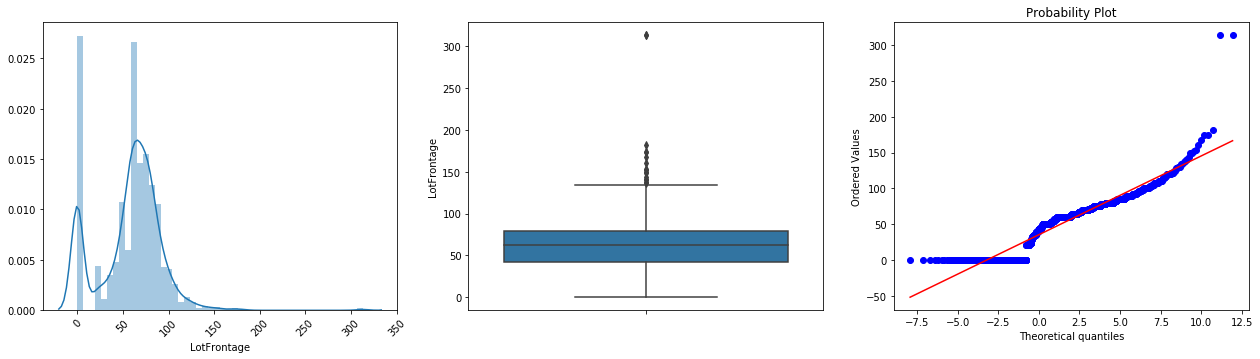

In [129]:
# univariate plots
hist_box_qq_plot(df_train_new['LotFrontage'].fillna(0))

LotFrontage     1.000000
1stFlrSF        0.457181
LotArea         0.426095
GrLivArea       0.402797
TotalBsmtSF     0.392075
TotRmsAbvGrd    0.352096
SalePrice       0.351799
GarageArea      0.344997
Name: LotFrontage, dtype: float64


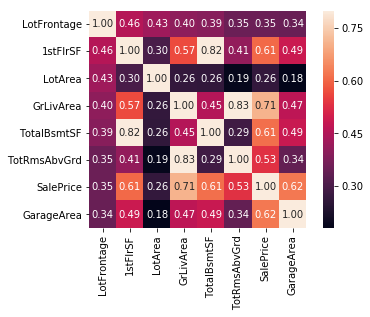

In [130]:
# numeric variables with high correlation (>0.3) with LotFrontage
tmp = df_train_new[num_cols + ordinal_cols + ['SalePrice']].corr()['LotFrontage'][lambda x: abs(x) > 0.3].sort_values(ascending=False)
print(tmp)
sns.heatmap(df_train_new[tmp.index].corr(), vmax=.8, square=True, annot=True, fmt='.2f')

In [131]:
# double check no missing value in correlated columns
tmp_cols = [x for x in tmp.index.values if x not in ['LotFrontage', 'SalePrice', 'TotalBsmtSF', 'GarageArea']]
show_missing(df_train_new[tmp_cols], df_test_new[tmp_cols])
print("These columns can be used to impute LotFrontage:", tmp_cols)

0 out of 4 variables contain missing values:

These columns can be used to impute LotFrontage: ['1stFlrSF', 'LotArea', 'GrLivArea', 'TotRmsAbvGrd']


LotFrontage is imputed using linear regression.


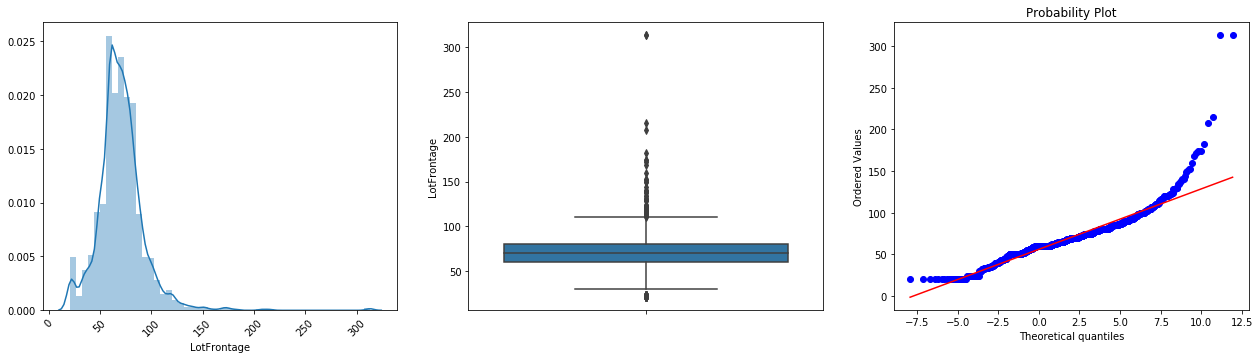

In [132]:
class impute_with_regression(base.BaseEstimator, base.TransformerMixin):
    ''' impute a column with missing value using regression on other correlated columns
    '''
    def __init__(self, col, correlated_cols, model=linear_model.LinearRegression()):
        self.col = col
        self.correlated_cols = correlated_cols
        self.model = model
    
    def fit(self,X,y=None):
        X_corr = X.loc[X[self.col].notnull(), self.correlated_cols].values
        X_col = X.loc[X[self.col].notnull(), self.col].values
        self.model.fit(X_corr, X_col)
        return self
    
    def transform(self,X):
        df = X.copy()
        df.loc[df[self.col].isnull(), self.col] = self.model.predict(df.loc[df[self.col].isnull(), self.correlated_cols])
        return df
    
# exmpale: 
e = impute_with_regression('LotFrontage', ['1stFlrSF', 'LotArea', 'GrLivArea', 'TotRmsAbvGrd'])
df_train_new = e.fit_transform(df_train_new)
df_test_new = e.transform(df_test_new)

print('LotFrontage is imputed using linear regression.')
hist_box_qq_plot(df_train_new['LotFrontage'])

##### Impute other num_cols and cat_cols

In [133]:
class impute_cat_num_general(base.BaseEstimator, base.TransformerMixin):
    ''' impute all numeric variables with median, and all categorical variables with 'NA'
    '''
    def __init__(self, cat_impute = 'NA'):
        self.cat_impute = cat_impute
    
    def fit(self,X,y=None):
        self.value_dict = X.mean().to_dict()
        return self
    
    def transform(self,X):
        df = X.copy()
        null_cols = df.isnull().sum()[lambda x: x>0].index
        object_cols = df[null_cols].select_dtypes(['O']).columns
        # fill num cols
        df.fillna(self.value_dict, inplace=True)
        # fill cat cols
        df.fillna(dict(zip(object_cols, [self.cat_impute] * len(object_cols))), inplace=True)
        return df

# example
e = impute_cat_num_general()
e.fit(df_train_new)
df_train_new = e.transform(df_train_new)
df_test_new = e.transform(df_test_new)
show_missing(df_train_new, df_test_new)

0 out of 81 variables contain missing values:



,train,test,train_count,test_count


### Creating new features

- Sum up living area, no. rooms, bathroom, etc..
- Calculate Age, IsRemodelled, IsNewHouse by combining two or more variables
- Binning Neighborhood 

##### Summing up all Bath rooms

Summing up 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', with 0.5 weight for 'half', improved the correlation with target variable.

In [134]:
# Try different options to see if correlation with target variable increases

tmp_cols = [x for x in num_cols if any([i in x.lower() for i in ['bath']])]
tmp = df_train_new[tmp_cols + ['SalePrice']].corr()['SalePrice'].sort_values(ascending=False)

new_feature1 = df_train_new['FullBath'] + 0.5 * df_train_new['HalfBath']
new_feature2 = df_train_new['BsmtFullBath'] + 0.5 * df_train_new['BsmtHalfBath']
new_feature3 = new_feature1 + new_feature2

# calculate corr of new features with target variable
tmp.loc['FullBath+0.5HalfBath'], _ = stats.pearsonr(new_feature1, df_train_new['SalePrice'])
tmp.loc['BsmtFullBath+0.5BsmtHalfBath'], _ = stats.pearsonr(new_feature2, df_train_new['SalePrice'])
tmp.loc['AllBath'], _ = stats.pearsonr(new_feature3, df_train_new['SalePrice'])

print(tmp)

SalePrice                       1.000000
FullBath                        0.560664
HalfBath                        0.284108
BsmtFullBath                    0.227122
BsmtHalfBath                   -0.016844
FullBath+0.5HalfBath            0.597966
BsmtFullBath+0.5BsmtHalfBath    0.224953
AllBath                         0.631731
Name: SalePrice, dtype: float64


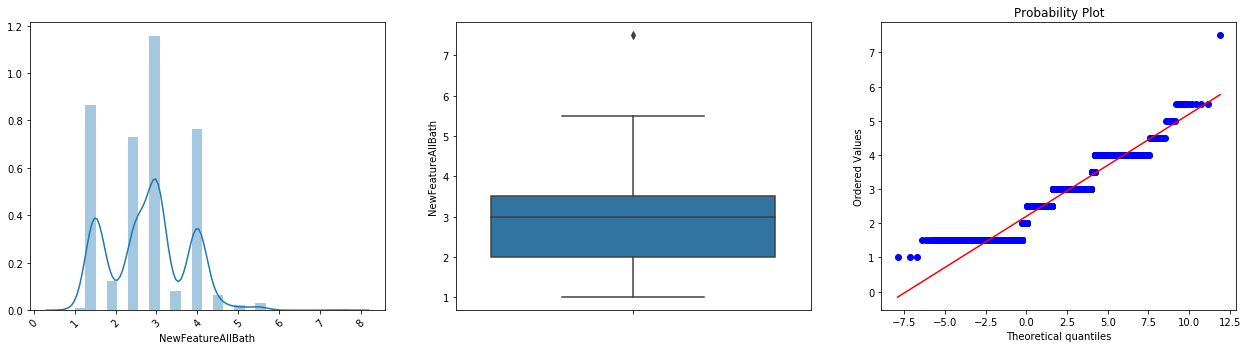

In [135]:
# Create AllBath feature

def lambda_calc_all_bath(x):
    return x['FullBath'] + 0.5 * x['FullBath'] + x['BsmtFullBath'] + 0.5 * x['BsmtHalfBath']

class new_feature_AllBath(base.BaseEstimator, base.TransformerMixin):
    ''' add all bathrooms
    '''
    def __init__(self):
        pass
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        df = X.copy()
        df['NewFeatureAllBath'] = df.apply(lambda_calc_all_bath, axis=1)
        return df
    
df_train_new = new_feature_AllBath().fit_transform(df_train_new)
df_test_new = new_feature_AllBath().fit_transform(df_test_new)

hist_box_qq_plot(df_train_new['NewFeatureAllBath'])

##### Binning Neighborhood

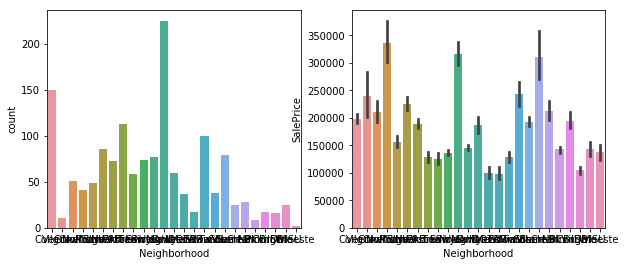

In [136]:
plot_count_and_bar('Neighborhood', 'SalePrice', df_train_new)

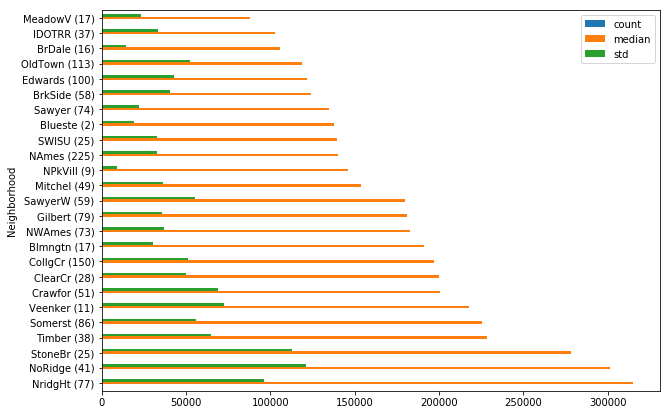

In [137]:
tmp_nb = df_train_new.groupby('Neighborhood')['SalePrice'].agg(['count', np.median, np.std]).sort_values(by='median', ascending=False)
ax = tmp_nb.plot(kind='barh', figsize=(10,7))

ax.set_yticklabels([x+ ' ({})'.format(tmp_nb.loc[x, 'count']) for x in tmp_nb.index])
plt.show()

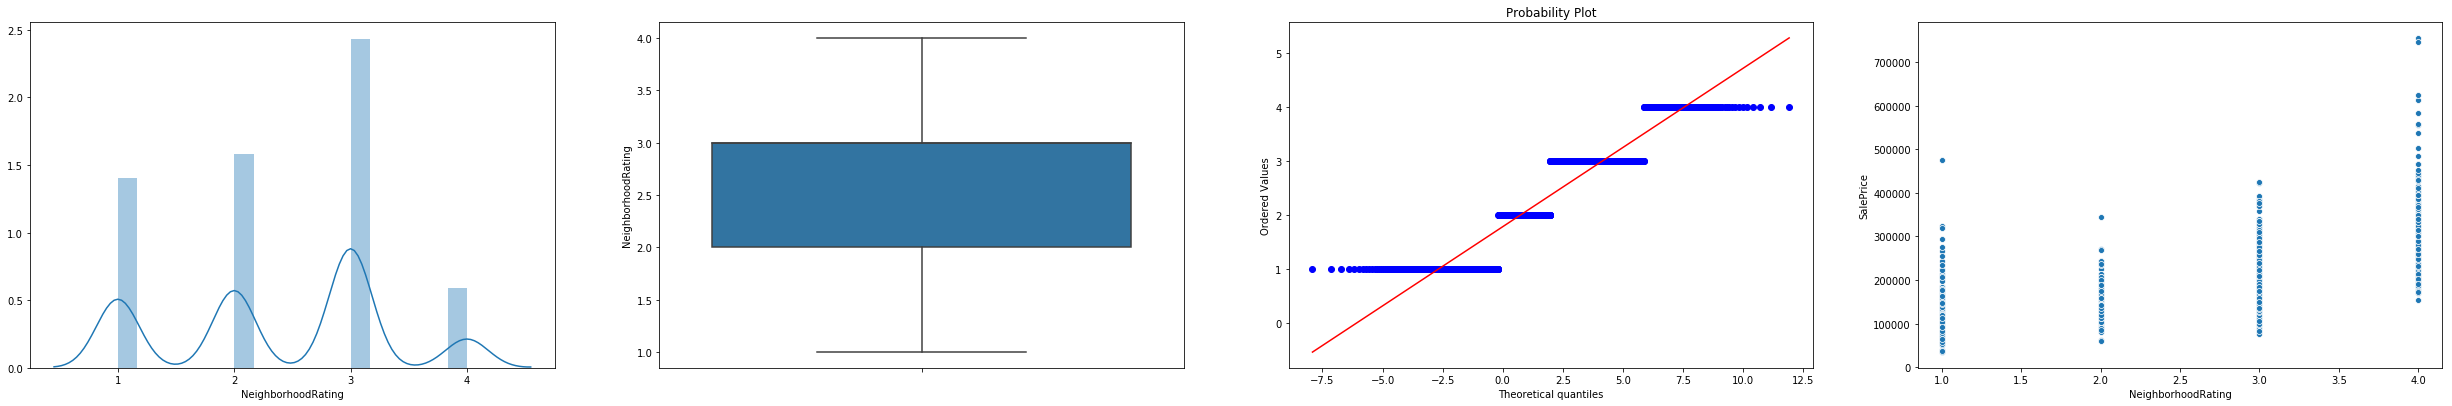

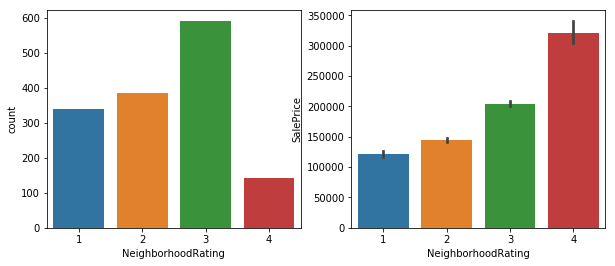

In [138]:
segments = [
    ['NridgHt', 'NoRidge', 'StoneBr'],
    ['Timber', 'Somerst', 'Veenker', 'Crawfor', 'ClearCr', 'CollgCr', 'Blmngtn', 'NWAmes', 'Gilbert', 'SawyerW'], 
    ['Mitchel', 'NPkVill', 'NAmes', 'SWISU', 'Blueste', 'Sawyer'], 
    ['BrkSide', 'Edwards', 'OldTown', 'BrDale', 'IDOTRR', 'MeadowV']
]

map_dict = {}
for i, seg in enumerate(segments):
    map_dict.update(dict(zip(seg, [len(segments) - i] * len(seg))))

df_train_new['Neighborhood'].map(map_dict)

class rate_neighborhood(base.BaseEstimator, base.TransformerMixin):
    ''' create a new rating for Neighborhood 
    '''
    def __init__(self):
        pass
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        df = X.copy()
        df['NeighborhoodRating'] = df['Neighborhood'].map(map_dict)
        return df
    
df_train_new = rate_neighborhood().fit_transform(df_train_new)
df_test_new = rate_neighborhood().fit_transform(df_test_new)

plot_hist_box_qq_scatter('NeighborhoodRating', 'SalePrice', df_train_new)
plot_count_and_bar('NeighborhoodRating', 'SalePrice', df_train_new)

##### Check skewness of important numeric variables and apply log-transform

In [139]:
corr = df_train_new.select_dtypes(exclude='O').corr()['SalePrice'][lambda x: abs(x) > 0.3].sort_values(ascending=False).rename('corr_SalePrice')
skewness = df_train_new[corr.index.values].apply(stats.skew).rename('skewness')
print(pd.concat([corr, skewness], axis=1, sort=False))

# candidates = ['GrLivArea', 'TotalBsmtSF', '1stFlrSF', 'MasVnrArea']
# for col in candidates:
#     plot_hist_box_qq_scatter(col, 'SalePrice', df_train_new)
    
candidates = corr.index.values

tmp_out = pd.concat([corr,
                     df_train_new[candidates].apply(stats.skew).rename('skewness'),
                 df_train_new[candidates].apply(np.log1p).apply(stats.skew).rename('skewness_after_log_transform'),
          ],
          axis=1
         ).sort_values('skewness', ascending=False)

tmp_out

                    corr_SalePrice  skewness
SalePrice                 1.000000  1.880941
OverallQual               0.790982  0.216721
GrLivArea                 0.708624  1.365156
NeighborhoodRating        0.673739 -0.097276
GarageCars                0.640409 -0.342197
GarageArea                0.623431  0.179796
NewFeatureAllBath         0.616688  0.230525
TotalBsmtSF               0.613581  1.522688
1stFlrSF                  0.605852  1.375342
FullBath                  0.560664  0.036524
TotRmsAbvGrd              0.533723  0.675646
YearBuilt                 0.522897 -0.612831
YearRemodAdd              0.507101 -0.503044
MasVnrArea                0.475241  2.673661
GarageYrBlt               0.470177 -0.667488
Fireplaces                0.466929  0.648898
BsmtFinSF1                0.386420  1.683771
LotFrontage               0.367911  2.313072
WoodDeckSF                0.324413  1.539792
2ndFlrSF                  0.319334  0.812194
OpenPorchSF               0.315856  2.361912


,corr_SalePrice,skewness,skewness_after_log_transform
MasVnrArea,0.475241,2.673661,0.480626
OpenPorchSF,0.315856,2.361912,-0.023373
LotFrontage,0.367911,2.313072,-0.719219
SalePrice,1.000000,1.880941,0.121222
BsmtFinSF1,0.386420,1.683771,-0.617774
WoodDeckSF,0.324413,1.539792,0.153379
TotalBsmtSF,0.613581,1.522688,-5.149373
1stFlrSF,0.605852,1.375342,0.080032
GrLivArea,0.708624,1.365156,-0.006134
2ndFlrSF,0.319334,0.812194,0.289346


In [140]:
cols_for_log_transform = ['MasVnrArea', 'OpenPorchSF', 'LotFrontage', 'BsmtFinSF1',
       'WoodDeckSF', '1stFlrSF', 'GrLivArea']


class log_transform(base.BaseEstimator, base.TransformerMixin):
    ''' log transform some features, replace original ones
    '''
    def __init__(self):
        pass
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        df = X.copy()
        df[cols_for_log_transform] = df[cols_for_log_transform].apply(np.log1p)
        return df
    
df_train_new = log_transform().fit_transform(df_train_new)
df_test_new = log_transform().fit_transform(df_test_new)

#### Outliers detection

We take a look at the 10 numeric variables that are most correlated with SalePrice.

Based on the scatter plots, we decide to remove ID: 1299, 1062 and 739

In [141]:
corr = df_train_new.select_dtypes(exclude='O').corr()['SalePrice'][lambda x: abs(x) > 0.3].sort_values(ascending=False).rename('corr_SalePrice')
corr.head(11), corr.head(11).index

(SalePrice             1.000000
 OverallQual           0.790982
 GrLivArea             0.695147
 NeighborhoodRating    0.673739
 GarageCars            0.640409
 GarageArea            0.623431
 NewFeatureAllBath     0.616688
 TotalBsmtSF           0.613581
 1stFlrSF              0.591299
 FullBath              0.560664
 TotRmsAbvGrd          0.533723
 Name: corr_SalePrice, dtype: float64,
 Index(['SalePrice', 'OverallQual', 'GrLivArea', 'NeighborhoodRating',
        'GarageCars', 'GarageArea', 'NewFeatureAllBath', 'TotalBsmtSF',
        '1stFlrSF', 'FullBath', 'TotRmsAbvGrd'],
       dtype='object'))

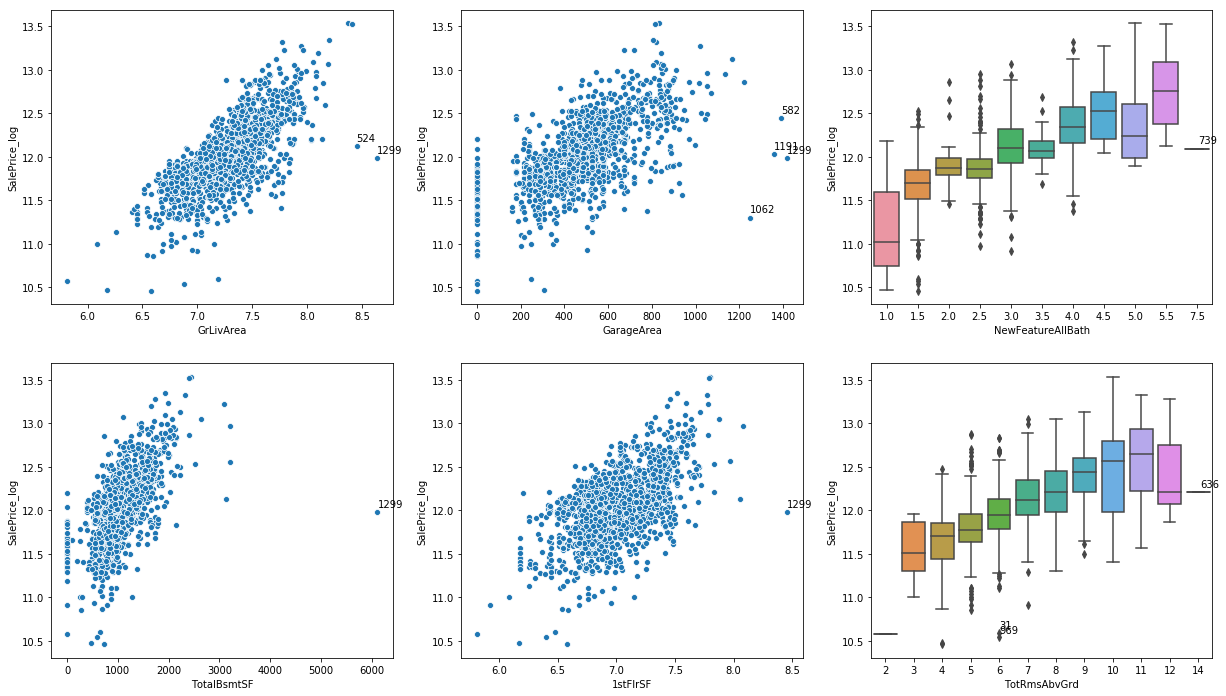

In [142]:
# scatter plots + annotate outliers

cols = ['GrLivArea', 'GarageArea', 'NewFeatureAllBath', 'TotalBsmtSF',
        '1stFlrSF', 'TotRmsAbvGrd']

df_train_new['SalePrice_log']  = df_train_new['SalePrice'].apply(np.log1p)

_, ax = plt.subplots(int(np.ceil(len(cols)/3)), 3, figsize=(15, int(np.ceil(len(cols)/3)) * 5))


# a counter
it = iter(range(len(cols)))

i = next(it)
this_ax = sns.scatterplot(x='GrLivArea', y='SalePrice_log', data=df_train_new, ax=ax[int(np.floor(i/3)) , i%3])
outliers = df_train_new.loc[(df_train_new['GrLivArea'] > 8.2) & (df_train_new['SalePrice_log'] < 12.5), ['Id', 'GrLivArea', 'SalePrice_log']]
for _, row in outliers.iterrows():
    this_ax.annotate(int(row['Id']), xy=(row['GrLivArea'], row['SalePrice_log']), 
                     xytext=(0, 5), 
                     textcoords='offset points')

i = next(it)
this_ax = sns.scatterplot(x='GarageArea', y='SalePrice_log', data=df_train_new, ax=ax[int(np.floor(i/3)) , i%3])
outliers = df_train_new.loc[(df_train_new['GarageArea'] > 1200) & (df_train_new['SalePrice_log'] < 12.5), ['Id', 'GarageArea', 'SalePrice_log']]
for _, row in outliers.iterrows():
    this_ax.annotate(int(row['Id']), xy=(row['GarageArea'], row['SalePrice_log']), 
                     xytext=(0, 5), 
                     textcoords='offset points')

i = next(it)
this_ax = sns.boxplot(x='NewFeatureAllBath', y='SalePrice_log', data=df_train_new, ax=ax[int(np.floor(i/3)) , i%3])
outliers = df_train_new.loc[(df_train_new['NewFeatureAllBath'] > 7) & (df_train_new['SalePrice_log'] < 12.5), ['Id', 'NewFeatureAllBath', 'SalePrice_log']]
map_xaxis_value_to_loc = dict(zip([x._text for x in this_ax.xaxis.get_ticklabels()], this_ax.xaxis.get_ticklocs()))
for _, row in outliers.iterrows():
    xloc = map_xaxis_value_to_loc[str(row['NewFeatureAllBath'])]
    this_ax.annotate(int(row['Id']), xy=( xloc * 1.005, row['SalePrice_log'] * 1.005))
    

i = next(it)
this_ax = sns.scatterplot(x='TotalBsmtSF', y='SalePrice_log', data=df_train_new, ax=ax[int(np.floor(i/3)) , i%3])
outliers = df_train_new.loc[(df_train_new['TotalBsmtSF'] > 5000) & (df_train_new['SalePrice_log'] < 12.5), ['Id', 'TotalBsmtSF', 'SalePrice_log']]
for _, row in outliers.iterrows():
    this_ax.annotate(int(row['Id']), xy=(row['TotalBsmtSF'], row['SalePrice_log']), 
                     xytext=(0, 5), 
                     textcoords='offset points')
    

i = next(it)
this_ax = sns.scatterplot(x='1stFlrSF', y='SalePrice_log', data=df_train_new, ax=ax[int(np.floor(i/3)) , i%3])
outliers = df_train_new.loc[(df_train_new['1stFlrSF'] > 8.2) & (df_train_new['SalePrice_log'] < 12.5), ['Id', '1stFlrSF', 'SalePrice_log']]
for _, row in outliers.iterrows():
    this_ax.annotate(int(row['Id']), xy=(row['1stFlrSF'], row['SalePrice_log']), 
                     xytext=(0, 5), 
                     textcoords='offset points')
    

i = next(it)
this_ax = sns.boxplot(x='TotRmsAbvGrd', y='SalePrice_log', data=df_train_new, ax=ax[int(np.floor(i/3)) , i%3])
outliers = df_train_new.loc[(df_train_new['TotRmsAbvGrd'] > 13) & (df_train_new['SalePrice_log'] < 12.5), ['Id', 'TotRmsAbvGrd', 'SalePrice_log']]
outliers = outliers.append(df_train_new.loc[(df_train_new['TotRmsAbvGrd'] == 6.0) & (df_train_new['SalePrice_log'] < 10.8), ['Id', 'TotRmsAbvGrd', 'SalePrice_log']])
map_xaxis_value_to_loc = dict(zip([x._text for x in this_ax.xaxis.get_ticklabels()], this_ax.xaxis.get_ticklocs()))
for _, row in outliers.iterrows():
    xloc = map_xaxis_value_to_loc[str(int(row['TotRmsAbvGrd']))]
    this_ax.annotate(int(row['Id']), xy=(xloc * 1.005, row['SalePrice_log'] * 1.005))


plt.subplots_adjust(bottom=0.1, right=1.2, top=1.0)  # adjust subplots so that they do not overlap    

In [143]:
# outlier_id_to_remove = [1299, 1062, 739]


class remove_outlier_by_id(base.BaseEstimator, base.TransformerMixin):
    ''' remove outliers by id
    '''
    def __init__(self, outlier_ids):
        self.outlier_ids = outlier_ids
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        df = X[~X['Id'].isin(self.outlier_ids)]
        return df
    

df_train_new = remove_outlier_by_id([1299, 1062, 739]).fit_transform(df_train_new)
df_test_new = remove_outlier_by_id([1299, 1062, 739]).fit_transform(df_test_new)

#### Scaling numeric features

In [147]:
class num_standard_scaler(base.BaseEstimator, base.TransformerMixin):
    ''' apply standard scaler on numeric values 
    '''
    def __init__(self):
        self.scaler = preprocessing.StandardScaler()
    
    def fit(self,X,y=None):
        X_num = X.select_dtypes(exclude=['O'])
        self.num_cols = X_num.columns.tolist() 
        self.scaler.fit(X_num)
        return self
    
    def transform(self,X):
        df = X.copy()
        df.loc[:, self.num_cols] = self.scaler.transform(df.loc[:, self.num_cols])
        return df

# example
e = num_standard_scaler()
e.fit(df_train_new.drop(['SalePrice', 'SalePrice_log'], axis=1))
_ = e.transform(df_train_new.drop(['SalePrice', 'SalePrice_log'], axis=1))
__ = e.transform(df_test_new)
# print(_.mean(), __.mean())

Id                    5.059630e-17
MSSubClass                     inf
LotFrontage           2.072810e-15
LotArea              -7.845665e-17
OverallQual           1.914125e-16
OverallCond           3.608796e-16
YearBuilt            -7.746796e-16
YearRemodAdd         -4.940226e-15
MasVnrArea           -3.877018e-16
BsmtFinSF1           -1.056122e-16
BsmtFinSF2           -2.087859e-17
BsmtUnfSF             5.920681e-17
TotalBsmtSF          -1.619234e-16
1stFlrSF             -1.491067e-15
2ndFlrSF              1.581896e-16
LowQualFinSF         -7.585445e-16
GrLivArea             1.613138e-16
BsmtFullBath         -4.876752e-18
BsmtHalfBath         -1.575419e-16
FullBath              3.657564e-18
HalfBath              1.036310e-17
BedroomAbvGr         -1.915840e-16
KitchenAbvGr         -2.893666e-16
TotRmsAbvGrd          2.339317e-17
Fireplaces           -1.005830e-17
GarageYrBlt          -5.745423e-17
GarageCars            1.655048e-16
GarageArea            4.472896e-17
WoodDeckSF          

#### One Hot Encoding for categorical variables

In [223]:
class my_ohe(base.BaseEstimator, base.TransformerMixin):
    ''' apply OHE on categorical values 
            - fit only on train data
            - new categories in test data are replaced by mode
            - keep encoded column names
    '''
    def __init__(self):
        self.ohe = preprocessing.OneHotEncoder(sparse=False)
    
    def fit(self,X,y=None):
        X_cat = X.select_dtypes(include=['O'])
        self.cat_cols = X_cat.columns.tolist() 
        self.ohe.fit(X_cat)
        self.feature_names = self.ohe.get_feature_names(self.cat_cols)
        self.df_allowed_values = pd.DataFrame([ [c, set(X_cat[c].unique()), X_cat[c].mode()[0]] for c in self.cat_cols],
                                              columns = ['Column_name', 'Allowed_Values', 'Mode'],
                                             ).set_index('Column_name')
        return self
    
    def transform(self,X):
        df = X.copy()
        # check if values are in self.df_allowed_values, if not, replace with mode value
        for col in self.cat_cols:
            new_values = set(df[col].unique()) - self.df_allowed_values.loc[col, 'Allowed_Values']
            if len(new_values) > 0:
                df[col] = df[col].replace(dict(zip(new_values, [self.df_allowed_values.loc[col, 'Mode']] * len(new_values))))
        new_df = pd.DataFrame(self.ohe.transform(df[self.cat_cols]), columns=self.feature_names)
        df = df.drop(self.cat_cols, axis=1)
        df = pd.concat([df, new_df.set_index(df.index)], axis=1)
        return df

# example
e = my_ohe()
e.fit(df_train_new.drop(['SalePrice', 'SalePrice_log'], axis=1))
_ = e.transform(df_train_new.drop(['SalePrice', 'SalePrice_log'], axis=1))
__ = e.transform(df_test_new)
print(_.shape, __.shape)

(1457, 335) (1459, 335)


#### Build data transformation pipeline

In [224]:
# build data transformation pipeline
pipe = pipeline.make_pipeline(ordinal_encode(), 
                              num2cat(),
                              impute_with_regression('LotFrontage', ['1stFlrSF', 'LotArea', 'GrLivArea', 'TotRmsAbvGrd']),
                              impute_cat_num_general(),      
                              new_feature_AllBath(),
                              rate_neighborhood(),
                              log_transform(),
                              remove_outlier_by_id([1299, 1062, 739]),
                              drop_cols(),
                              num_standard_scaler(),
                              my_ohe(),                              
                             )

_ = pipe.fit_transform(df_train.drop('SalePrice', axis=1))
__ = pipe.transform(df_test)
print(df_train.shape, df_test.shape)
print(_.shape, __.shape)
pd.set_option('display.max_columns', None)
_.head()

(1460, 81) (1459, 80)
(1457, 281) (1459, 281)


,LotFrontage,LotArea,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageYrBlt,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,MiscVal,NewFeatureAllBath,NeighborhoodRating,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Alley_Grvl,Alley_NA,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_NA,MasVnrType_None,MasVnrType_Stone,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_NA,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_NA,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_NA,Electrical_SBrkr,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_NA,GarageFinish_Fin,GarageFinish_NA,GarageFinish_RFn,GarageFinish_Unf,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_NA,MiscFeature_Gar2,MiscFeature_NA,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,MoSold_1,MoSold_10,MoSold_11,MoSold_12,MoSold_2,MoSold_3,MoSold_4,MoSold_

## EDA

- Univariate (Targe Variable)
- Univariate (Num, cat)
- Bivariate, correlation
- PCA

### Check target variable distribution

- SalePrice is heavy skewed to the right. Its distribution becomes closer to normal after log-transform. 

- Even for tree-based algorithms, applying log-transform on target variable can reduce the imfluence of large values on MSE. 

skewness of original series:  1.880940746034036
skewness of after log-transform:  0.12122191311528363


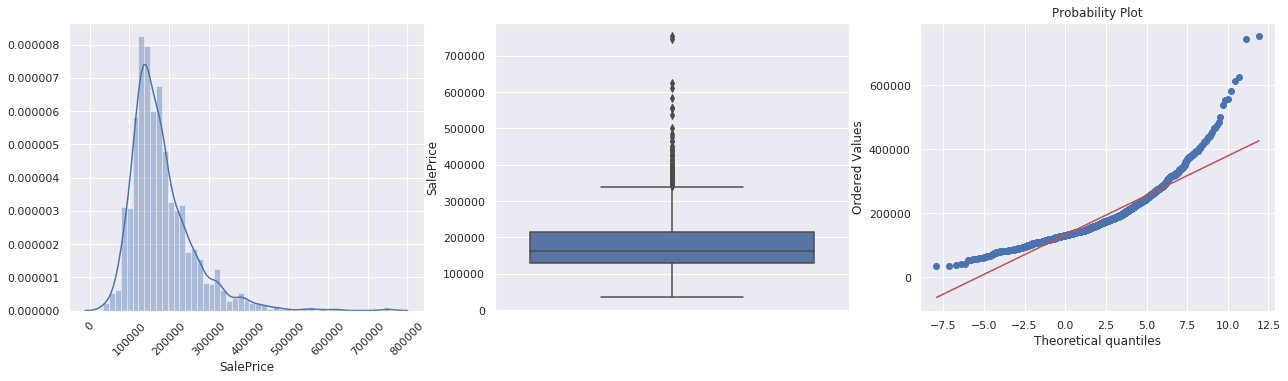

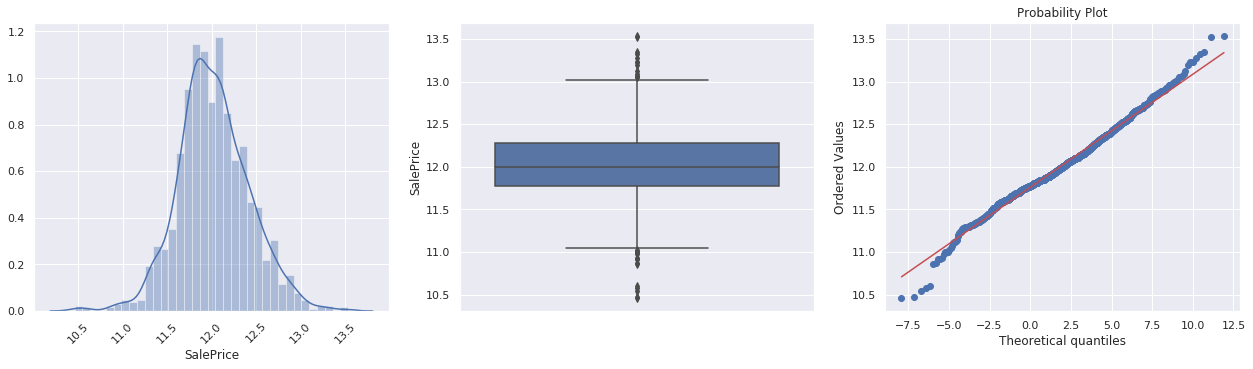

In [290]:
s = df_train['SalePrice']
print("skewness of original series: ", stats.skew(s))
hist_box_qq_plot(s)
print("skewness of after log-transform: ", stats.skew(s.apply(np.log1p)))
hist_box_qq_plot(s.apply(np.log1p))

In [234]:
pipe_eda = pipeline.make_pipeline(ordinal_encode(), 
                              num2cat(),
                              impute_with_regression('LotFrontage', ['1stFlrSF', 'LotArea', 'GrLivArea', 'TotRmsAbvGrd']),
                              impute_cat_num_general(),      
                              new_feature_AllBath(),
                              rate_neighborhood(),
                              log_transform(),
                              remove_outlier_by_id([1299, 1062, 739]),
                              drop_cols(),
#                               num_standard_scaler(),
#                               my_ohe(),                              
                             )

df_train_eda = pipe_eda.fit_transform(df_train.drop('SalePrice', axis=1))
df_train_eda['SalePrice'] = df_train['SalePrice']
df_train_eda['SalePrice_log'] = df_train_eda['SalePrice'].apply(np.log1p)

#### Correlation with SalePrice for all num and ordinal variables

In [239]:
tmp_corr = df_train_eda.corr()[['SalePrice', 'SalePrice_log']][lambda x: abs(x['SalePrice']) > 0.5].sort_values(by='SalePrice', ascending=False)
tmp_corr

,SalePrice,SalePrice_log
SalePrice,1.000000,0.948413
SalePrice_log,0.948413,1.000000
OverallQual,0.793704,0.819461
GrLivArea,0.699669,0.734529
ExterQual,0.684760,0.680194
NeighborhoodRating,0.674038,0.724944
KitchenQual,0.661112,0.669377
TotalBsmtSF,0.645835,0.643161
GarageCars,0.644071,0.685734
GarageArea,0.635924,0.665337


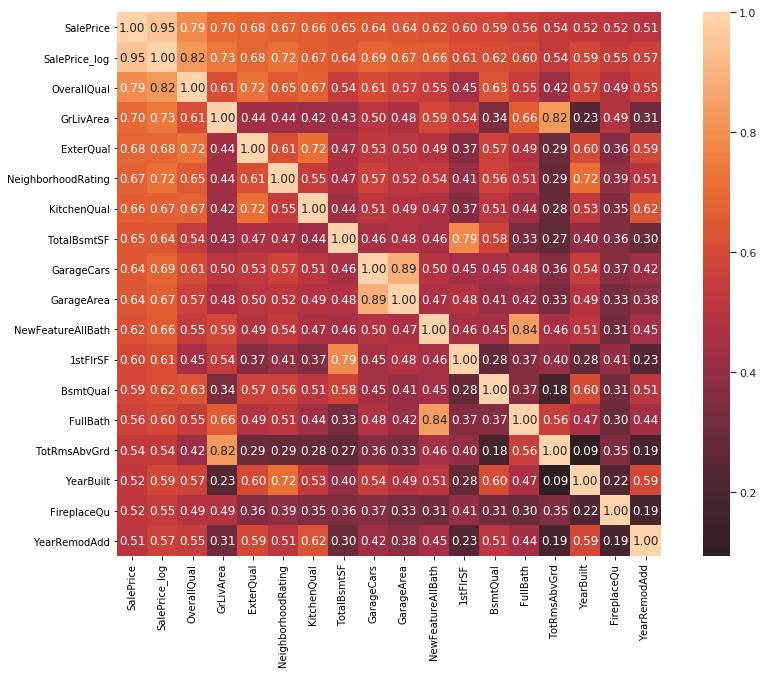

In [240]:
_, ax = plt.subplots(figsize=(15,10))
sns.set(font_scale=1.0)
sns.heatmap(df_train_eda[tmp_corr.index].corr(), square=True, center=0.0, ax=ax, annot=True, fmt='.2f')

#### PCA

95% of the variance is explained by the first 170 PCs (out of 281)

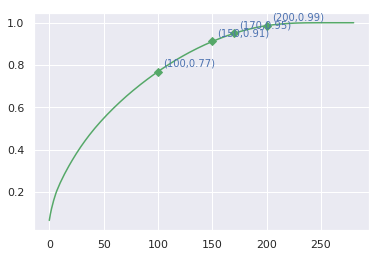

In [271]:
pipe_pca = pipeline.make_pipeline(ordinal_encode(), 
                              num2cat(),
                              impute_with_regression('LotFrontage', ['1stFlrSF', 'LotArea', 'GrLivArea', 'TotRmsAbvGrd']),
                              impute_cat_num_general(),      
                              new_feature_AllBath(),
                              rate_neighborhood(),
                              log_transform(),
                              remove_outlier_by_id([1299, 1062, 739]),
                              drop_cols(),
                              num_standard_scaler(),
                              my_ohe(),                              
                             )

df_train_pca = pipe_pca.fit_transform(df_train.drop('SalePrice', axis=1))


pca = decomposition.PCA(n_components=None, random_state=100)
pca.fit(preprocessing.StandardScaler().fit_transform(df_train_pca.values))
# print(pca.explained_variance_ratio_)
s = np.cumsum(pca.explained_variance_ratio_)
ax = plt.subplot()
ax.plot(s, '-gD', markevery=[100, 150, 170, 200])
for i in [100, 150, 170, 200]:
    ax.annotate('({},{:.2f})'.format(i, s[i]), xy=(i, s[i]), 
                 xytext=(5, 5), 
                 textcoords='offset points',
               fontsize=10, color='b')

#### Feature importance from Random Forest

In [277]:
X.describe()

,LotFrontage,LotArea,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageYrBlt,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,MiscVal,NewFeatureAllBath,NeighborhoodRating,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Alley_Grvl,Alley_NA,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_NA,MasVnrType_None,MasVnrType_Stone,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_NA,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_NA,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_NA,Electrical_SBrkr,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_NA,GarageFinish_Fin,GarageFinish_NA,GarageFinish_RFn,GarageFinish_Unf,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_NA,MiscFeature_Gar2,MiscFeature_NA,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,MoSold_1,MoSold_10,MoSold_11,MoSold_12,MoSold_2,MoSold_3,MoSold_4,MoSold_

In [287]:
pipe_fi = pipeline.make_pipeline(ordinal_encode(), 
                              num2cat(),
                              impute_with_regression('LotFrontage', ['1stFlrSF', 'LotArea', 'GrLivArea', 'TotRmsAbvGrd']),
                              impute_cat_num_general(),      
                              new_feature_AllBath(),
                              rate_neighborhood(),
                              log_transform(),
                              remove_outlier_by_id([1299, 1062, 739]),
                              drop_cols(),
#                               num_standard_scaler(),
                              my_ohe(),            
                              num_standard_scaler(),   # scale also OHE columns in order to compare FI for LASSO

                             )

X = pipe_fi.fit_transform(df_train.drop('SalePrice', axis=1))
y = df_train.loc[X.index, 'SalePrice'].apply(np.log1p)

model = ensemble.RandomForestRegressor(n_estimators=100)
model.fit(X.values, y)

df_feature = pd.DataFrame({'coef': model.feature_importances_}, index=X.columns).sort_values('coef', ascending=False)
df_feature.head(10)

,coef
OverallQual,0.541765
GrLivArea,0.098387
NeighborhoodRating,0.082625
TotalBsmtSF,0.029116
GarageCars,0.027368
GarageArea,0.025287
1stFlrSF,0.020999
BsmtFinSF1,0.019203
LotArea,0.010530
OverallCond,0.008794


#### Feature importance using Lasso

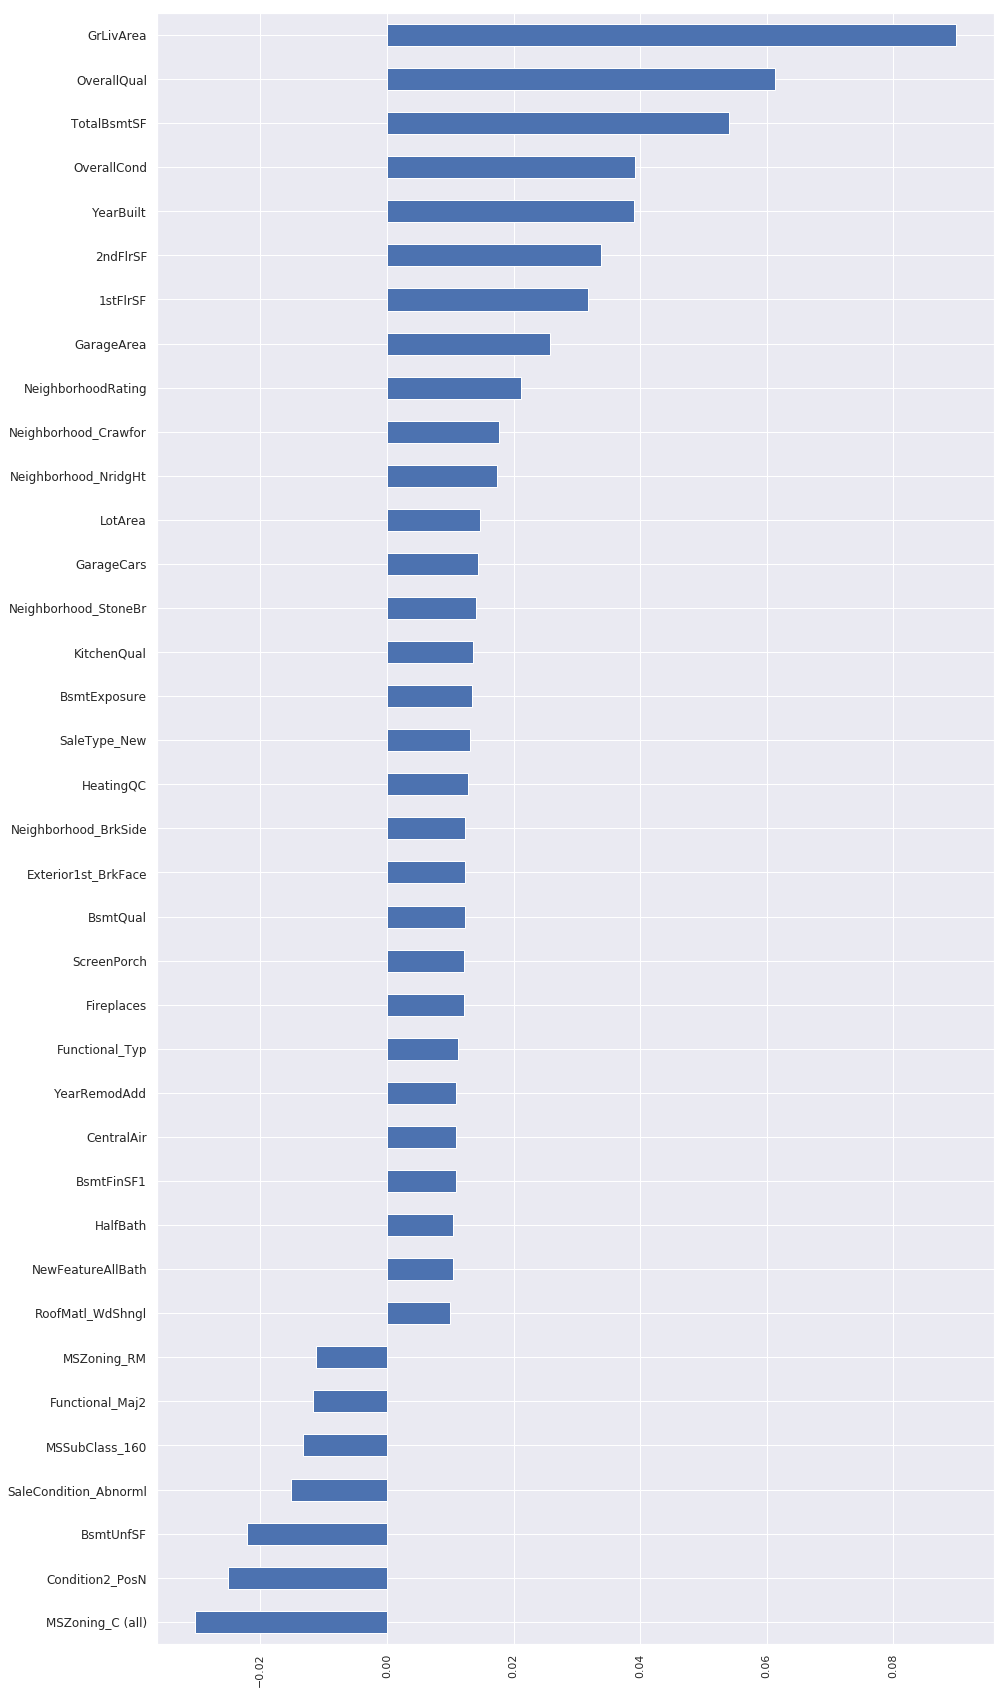

In [291]:

model = linear_model.Lasso(alpha=0.001)
model.fit(X.values, y)

df_feature = pd.DataFrame({'coef': model.coef_}, index=X.columns).sort_values('coef', ascending=False)

ax = df_feature['coef'][lambda x: abs(x)>0.01].sort_values(ascending=True).plot(kind="barh",figsize=(15,30))
plt.xticks(rotation=90)
plt.yticks(fontsize=12)
plt.show()

## Feature selection

## Modeling

In [311]:
# preprocessing 

pipe = pipeline.make_pipeline(ordinal_encode(), 
                              num2cat(),
                              impute_with_regression('LotFrontage', ['1stFlrSF', 'LotArea', 'GrLivArea', 'TotRmsAbvGrd']),
                              impute_cat_num_general(),      
                              new_feature_AllBath(),
                              rate_neighborhood(),
                              log_transform(),
                              remove_outlier_by_id([1299, 1062, 739]),
                              drop_cols(),
                              num_standard_scaler(),
                              my_ohe(),            
                             )

X = pipe.fit_transform(df_train.drop('SalePrice', axis=1))
y = df_train.loc[X.index, 'SalePrice'].apply(np.log1p)

X_test = pipe.transform(df_test)

In [300]:
from sklearn import linear_model, ensemble, model_selection, metrics, svm, tree, neighbors, neural_network
import xgboost


# list of regression models

candidate_models = [
#     linear_model.LinearRegression(),
    linear_model.Lasso(),
    linear_model.Ridge(), 
    linear_model.SGDRegressor(),
    neighbors.KNeighborsRegressor(),
    svm.SVR(),
    tree.DecisionTreeRegressor(),
    ensemble.RandomForestRegressor(),
    ensemble.GradientBoostingRegressor(),
    neural_network.MLPRegressor(),
    xgboost.XGBRegressor(),
]

In [301]:
# modeling

df_out = pd.DataFrame(columns=['model', 'model_spec', 'cv_score', 'cv_score_mean', 'cv_score_std'])

for i, model in enumerate(candidate_models):
    print("Cross validating the {}th model: ".format(i + 1))
    print(model)
    
    cv_score = model_selection.cross_val_score(model, X.values, y, cv=5, n_jobs=-1, 
                                               scoring='neg_mean_absolute_error',
                                              verbose=0)

    print("CV score: ", cv_score.mean(), '\n')  # --> sth. is wrong here 
    
    df_out.loc[i, 'model'] = type(model).__name__
    df_out.loc[i, 'model_spec'] = model
    df_out.loc[i, 'cv_score_mean'] = cv_score.mean()
    df_out.loc[i, 'cv_score_std'] = cv_score.std()
    df_out.ix[i, 'cv_score'] = cv_score.tolist()


Cross validating the 1th model: 
Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
CV score:  -0.30995369505331555 

Cross validating the 2th model: 
Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)
CV score:  -0.08423402340117851 

Cross validating the 3th model: 
SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:19: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated


CV score:  -0.20354908303959046 

Cross validating the 4th model: 
KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')
CV score:  -0.1170834512647975 

Cross validating the 5th model: 
SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)
CV score:  -0.082397249530576 

Cross validating the 6th model: 
DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')
CV score:  -0.1496949577052184 

Cross validating the 7th model: 
RandomForestRegressor(bootstrap=

In [303]:
df_out.sort_values(by='cv_score_mean', ascending=False, inplace=True)
df_out

,model,model_spec,cv_score,cv_score_mean,cv_score_std
4,SVR,"SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...","[-0.07836282454274697, -0.08788599941580884, -...",-0.0823972,0.00419669
1,Ridge,"Ridge(alpha=1.0, copy_X=True, fit_intercept=Tr...","[-0.08179992197034774, -0.08855017768665534, -...",-0.084234,0.00382388
7,GradientBoostingRegressor,"GradientBoostingRegressor(alpha=0.9, criterion...","[-0.08236885325505777, -0.09142006744942803, -...",-0.08651,0.00416535
9,XGBRegressor,"XGBRegressor(base_score=0.5, booster='gbtree',...","[-0.08296974036545766, -0.09001385081284806, -...",-0.0874373,0.00316529
6,RandomForestRegressor,"RandomForestRegressor(bootstrap=True, criterio...","[-0.10103572851605498, -0.10464752019903446, -...",-0.101335,0.00302088
3,KNeighborsRegressor,"KNeighborsRegressor(algorithm='auto', leaf_siz...","[-0.11299830069796842, -0.12011911053675726, -...",-0.117083,0.00354153
8,MLPRegressor,"MLPRegressor(activation='relu', alpha=0.0001, ...","[-0.15300480177943063, -0.1524853475993047, -0...",-0.144975,0.00808521
5,DecisionTreeRegressor,"DecisionTreeRegressor(criterion='mse', max_dep...","[-0.16026027054010017, -0.15697628271060848, -...",-0.149695,0.0074011
2,SGDRegressor,"SGDRegressor(alpha=0.0001, average=False, earl...","[-0.1871269238061091, -0.20427372862796472, -0...",-0.203549,0.0128663
0,Lasso,"Lasso(alpha=1.0, copy_X=True, fit_intercept=Tr...","[-0.30755564889795306, -0.33345047757231466, -...",-0.309954,0.0138322


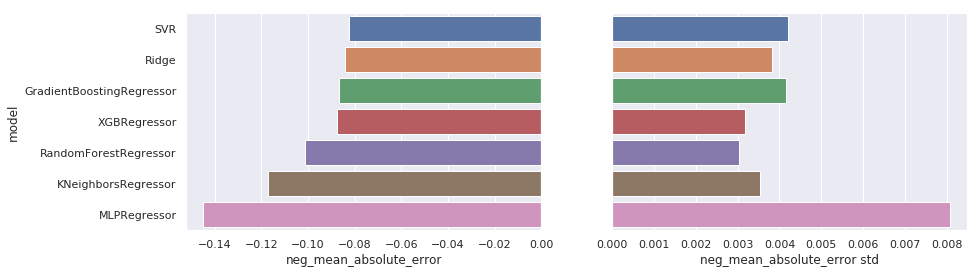

In [304]:
_, ax = plt.subplots(1, 2, figsize=(14, 4))
sns.barplot(x='cv_score_mean', y='model', data=df_out.head(7), ax=ax[0])
ax[0].set_xlabel('neg_mean_absolute_error')
sns.barplot(x='cv_score_std', y='model', data=df_out.head(7), ax=ax[1])
ax[1].set_xlabel('neg_mean_absolute_error std')
ax[1].yaxis.set_visible(False)

## Make prediction

In [312]:
model = xgboost.XGBRegressor()
# model = ensemble.RandomForestRegressor()
# model = linear_model.Lasso()

model.fit(X.values, y)

rmsle = np.sqrt(metrics.mean_squared_log_error(y, model.predict(X.values)))
print("RMSLE on training set: ", rmsle)

# feature importance
try:
    df_feature = pd.DataFrame({'coef': model.feature_importances_}, index=X.columns).sort_values('coef', ascending=False)
    df_feature.head(20)
except:
    print("no feature importance is produced.")


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:55:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSLE on training set:  0.006636082156944371


In [314]:
y_pred_log

array([11.732939, 11.94605 , 12.128202, ..., 11.95902 , 11.692728,
       12.230229], dtype=float32)

In [320]:
# create prediction and submit
y_pred_log = model.predict(X_test.values)
y_pred = np.expm1(y_pred_log)
make_submission_file(y_pred)

PL score: XGBOOST: 0.13787. a slight improvement from Round 1 (0.13921)

### Hyperparameter tuning